In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
            data_transforms[x])
            for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
           shuffle=True, num_workers=4)
           for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

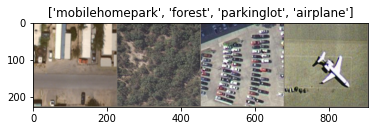

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
train_loss_his = []
train_acc_his = []
val_loss_his = []
val_acc_his = []

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
              train_loss_his.append(epoch_loss)
              train_acc_his.append(epoch_acc)
              print(epoch_acc)
            else:
              val_loss_his.append(epoch_loss)
              val_acc_his.append(epoch_acc)            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            label_temp = []
            for idx in labels:
              temp = f'{idx:.0f}'
              label_temp.append(class_names[int(temp)])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                if class_names[preds[j]] == label_temp[j]:
                  ax.title.set_color('blue')
                  ax.set_title(f'predicted: {class_names[preds[j]]}')
                else:
                  ax.title.set_color('red')
                  ax.set_title(f'predicted: {class_names[preds[j]]} /groundTruth: {label_temp[j]}')

                imshow(inputs.cpu().data[j])


                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
# PATH = 'model_2.pth'
# model_ft.load_state_dict(torch.load(PATH))
print(model_ft)


# num_ftrs = model_ft.fc.in_features
num_ftrs = 256
# Here the size of each output sample is set to 21.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 21)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.7041 Acc: 0.5289
tensor(0.5289, device='cuda:0', dtype=torch.float64)
val Loss: 1.7144 Acc: 0.5075
Epoch 1/49
----------
train Loss: 0.8301 Acc: 0.7432
tensor(0.7432, device='cuda:0', dtype=torch.float64)
val Loss: 1.1362 Acc: 0.6889
Epoch 2/49
----------
train Loss: 0.6223 Acc: 0.8075
tensor(0.8075, device='cuda:0', dtype=torch.float64)
val Loss: 1.1768 Acc: 0.7083
Epoch 3/49
----------
train Loss: 0.5669 Acc: 0.8267
tensor(0.8267, device='cuda:0', dtype=torch.float64)
val Loss: 1.4416 Acc: 0.6901
Epoch 4/49
----------
train Loss: 0.5299 Acc: 0.8379
tensor(0.8379, device='cuda:0', dtype=torch.float64)
val Loss: 1.0431 Acc: 0.7341
Epoch 5/49
----------
train Loss: 0.4664 Acc: 0.8616
tensor(0.8616, device='cuda:0', dtype=torch.float64)
val Loss: 1.0646 Acc: 0.7175
Epoch 6/49
----------
train Loss: 0.4246 Acc: 0.8719
tensor(0.8719, device='cuda:0', dtype=torch.float64)
val Loss: 1.1425 Acc: 0.7159
Epoch 7/49
----------
train Loss: 0.2382 Acc: 0.9264
te

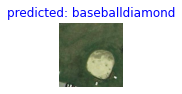

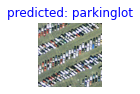

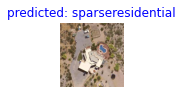

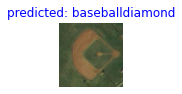

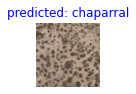

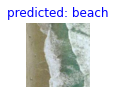

In [10]:
visualize_model(model_ft)

In [11]:
PATH = './model_FineTune_UCMerced.pth'
torch.save(model_ft.state_dict(), PATH)

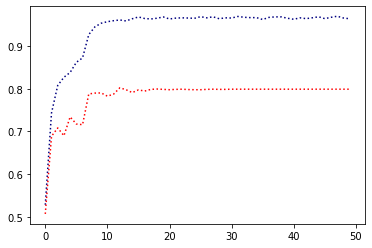

In [15]:
# train_loss_his
# train_acc_his 
# val_loss_his 
# val_acc_his
import matplotlib.pyplot as plt
import numpy as np
import json

train_acc = []
val_acc = []
for i in train_acc_his:
  temp = f'{i:.4f}'
  train_acc.append(float(temp))
for i in val_acc_his:
  temp = f'{i:.4f}'
  val_acc.append(float(temp))

plt.plot(train_acc, 'navy', linestyle = 'dotted', label = 'train_acc')
plt.plot(val_acc, 'red', linestyle = 'dotted', label = 'val_acc')
plt.show()


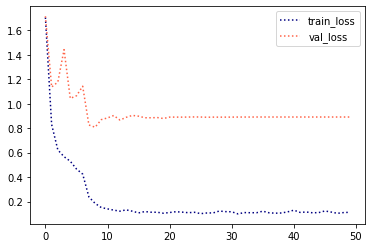

In [18]:
plt.plot(train_loss_his, 'navy', linestyle = 'dotted', label = 'train_loss')
plt.plot(val_loss_his, 'tomato', linestyle = 'dotted', label = 'val_loss')
plt.legend();
plt.show()